In [1]:
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd
import numpy as np
import vset, bounds
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

from dgp import *
import estimation, utils, experiments, plots, realdata

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


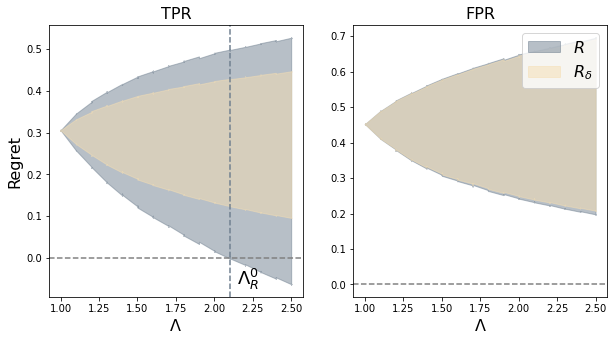

In [2]:
data = realdata.get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=2000)

dgp = {
    'N': 10000,
    'Dx': data['XU'].shape[1],
    'Du': 0,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'lambda': 2,
    'model': 'LR'
}

lambdas = np.arange(1, 2.6, .1)
data = realdata.get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=2000)
estimation.sample_split_crossfit(dgp, data, id_method='MSM', est_method='plugin', K=5)
brdf = experiments.design_sensitivity_exp(dgp, data, lambdas, n_sims=10)
plots.plot_design_sensitivity(brdf)


## Utility ratio curve

{'N': 10000, 'Dx': 11, 'Du': 0, 'nz': 10, 'beta_zy': 0, 'e1_coeffs': array([ 0.51623214,  1.66826124,  1.31881643,  0.48720887, -1.56181601,
       -1.59444802, -0.49232329, -1.38572586,  0.07811169,  1.897429  ,
        0.94836665]), 'z_coeffs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mu1_coeffs': array([-0.87514915,  0.98438607,  2.69156686,  0.14297641,  2.31580713,
       -0.51240948,  0.62060694,  1.26676789,  2.4098208 ,  1.81600426,
        2.28741756]), 'mu0_coeffs': array([-0.53279399, -0.35041372,  1.68069343, -1.643204  , -1.53145178,
       -0.30406178,  1.98961983,  0.56490919,  1.10540751,  1.06736428,
       -1.62244129]), 'lambda': 1.7, 'model': 'LR', 'id_assumption': 'MSM', 'lambda_star': 1.1236409824289273, 'beta_zd': 0}


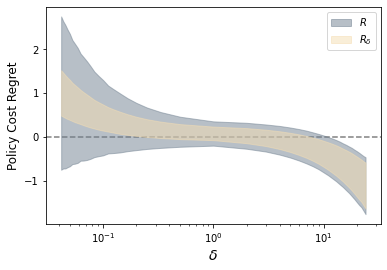

In [5]:
data = realdata.get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=2000)

nD =  data['XU'].shape[1]
dgp = {
    'N': 10000,
    'Dx': nD,
    'Du': 0,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.7,
    'model': 'LR'
}
dgp = set_dgp_config(dgp, 'MSM')
crdf = experiments.cost_ratio_sweep_exp(dgp, data, lam=1.7)
plots.plot_cost_ratio_curve(dgp, crdf)



## Evaluating the subgroup regret

In [105]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'Dx': data['XU'].shape[1],
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.2
}

In [112]:

n_sims = 20
K=2

bound_lists = []

data = get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=2000)
groups = [c for c in data.keys() if 'x_' in c]

for s in range(n_sims):

    u = np.array([[1,0], [0, 1]])
    dgp = set_dgp_config(dgp, 'MSM')
    
    for k in range(K):
        
        in_folds, out_folds = utils.k_fold_split_and_complement(data.copy(), K)

        # Set-up datasets for fold K
        in_data, out_data = in_folds[k], out_folds[k]
        in_dgp, out_dgp = dgp.copy(), dgp.copy()
        in_dgp['N'] = in_data['XU'].shape[0]
        out_dgp['N'] = out_data['XU'].shape[0]

        # Learn models, then run inference via data from fold k
        in_probs = estimation.plugin_nuisance_probs(in_dgp, out_dgp, in_data, out_data)
        
        # First add the population regret
        Vpf_down, Vpf_up = vset.get_vset(in_dgp, in_data, in_probs, id_method='MSM')
        bdf = bounds.get_bounds(in_data, Vpf_down, Vpf_up, u, verbose=False)
        bdf['g'] = '_Population'
        bdf['s'] = s
        bdf['selection_rate'] = in_data['D'].mean()
        bdf['size'] = 1
        bound_lists.append(bdf)

        # Add subgroup-level regret
        for g in groups: 
            gdata = utils.mask_dictionary_arrays(in_data.copy(), in_data[g])
            gprobs = utils.mask_dictionary_arrays(in_probs.copy(), in_data[g])

            # After learning the nuisance functions, we need to evaluate this over each subgroup
            Vpf_down, Vpf_up = vset.get_vset(in_dgp, gdata, gprobs, id_method='MSM')
            bdf = bounds.get_bounds(gdata, Vpf_down, Vpf_up, u, verbose=False)
            bdf['g'] = g
            bdf['s'] = s
            bdf['selection_rate'] = (gdata['D'] == 1).mean()
            bdf['size'] = gdata['XU'].shape[0] / in_data['XU'].shape[0]
            bound_lists.append(bdf)
            
group_bounds = pd.concat(bound_lists).groupby(['g', 's', 'metric']).mean().reset_index()

x_white_<65 yo
0
x_white_65+ yo
1
x_black_<65 yo
2
x_black_65+ yo
3
_Population
4


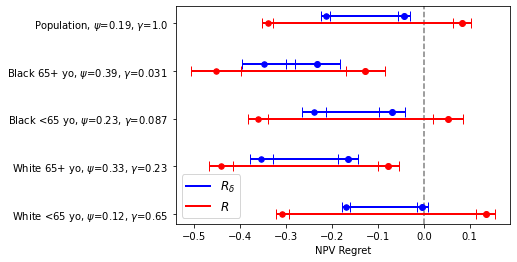

In [113]:
metric = 'm_a=0'

mdf = group_bounds[group_bounds['metric'] == metric].reset_index(drop=True)[::-1]
groups = mdf['g'].to_list()

plt.axvline(0, color='grey', zorder=1, linestyle='--')
gdfm = mdf.groupby(['g']).mean()[::-1].reset_index()

for ix, row in gdfm.iterrows():
    print(row['g'])
    print(ix)
    
    
    gdf = mdf[mdf['g'] == row['g']]
    
    plt.plot([row['Rs_down'], row['Rs_up']], [ix, ix], color='r', label="Rs", linewidth=2)
    plt.plot([row['Rd_down'], row['Rd_up']], [ix+.15, ix+.15], color='b', label="Rd", linewidth=2)
    
    plt.scatter(row['Rs_down'], ix,  color='r', s=30)
    plt.scatter(row['Rs_up'], ix, color='r', label="R")
    
    plt.scatter(row['Rd_down'], ix+.15,  color='b', s=30)
    plt.scatter(row['Rd_up'], ix+.15, color='b', label="R")
    
    sd = gdf['Rs_down'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rs_down'], ix, xerr=l_d, color='r', fmt='none', capsize=5, linewidth=2, elinewidth=2)

    
    sd = gdf['Rs_up'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rs_up'], ix, xerr=l_d, color='r', fmt='none', capsize=5, linewidth=2, elinewidth=2)

    
    sd = gdf['Rd_down'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rd_down'], ix+.15, xerr=l_d, color='b', fmt='none', capsize=5, linewidth=2, elinewidth=2)

    
    sd = gdf['Rd_up'].tolist()
    ci_d = sms.DescrStatsW(sd).tconfint_mean()
    l_d = abs(ci_d[1]-ci_d[0])
    plt.errorbar(row['Rd_up'], ix+.15, xerr=l_d, color='b', fmt='none', capsize=5, linewidth=2, elinewidth=2)




keys = [i for i in range(gdfm.shape[0])]
vals = realdata.get_group_descs(gdfm)
plt.yticks(keys, vals)

plt.xlabel(f'{utils.metric_dict[metric]} Regret')

# Create a custom legend
custom_legend = [
    plt.Line2D([0], [0], color='b', lw=2, label='$R_{\delta}$', linestyle='-'),
    plt.Line2D([0], [0], color='r', lw=2, label='$R$', linestyle='-'),
]

lgd = plt.legend(handles=custom_legend,  fontsize=12, loc='lower left')
plt.savefig('figs/subgroup_regret.pdf', dpi=500, bbox_inches='tight')